<a href="https://colab.research.google.com/github/vaibhavlokunde/AI-ML/blob/main/Tuberculosis_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving archive (1).zip to archive (1).zip


In [2]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score

In [10]:
import zipfile
import os

zip_path = "archive (1).zip"
extract_path = "tb_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Unzipped to:", extract_path)

✅ Unzipped to: tb_dataset


In [11]:
import os
import shutil

root = "tb_dataset"

nested_folders = [f for f in os.listdir(root) if os.path.isdir(os.path.join(root, f))]

for folder in nested_folders:
    full_path = os.path.join(root, folder)
    for subfolder in os.listdir(full_path):
        src = os.path.join(full_path, subfolder)
        dst = os.path.join(root, subfolder)
        if os.path.isdir(src):
            shutil.move(src, dst)

for folder in nested_folders:
    shutil.rmtree(os.path.join(root, folder), ignore_errors=True)

print("✅ Dataset structure fixed!")


✅ Dataset structure fixed!


In [12]:
import os
import shutil

root = "tb_dataset"
tb_src = os.path.join(root, "TB Chest X-rays")
normal_src = os.path.join(root, "Normal Chest X-rays")

tb_dst = os.path.join(root, "TB")
normal_dst = os.path.join(root, "Normal")

os.makedirs(tb_dst, exist_ok=True)
os.makedirs(normal_dst, exist_ok=True)

for file in os.listdir(tb_src):
    shutil.move(os.path.join(tb_src, file), os.path.join(tb_dst, file))

for file in os.listdir(normal_src):
    shutil.move(os.path.join(normal_src, file), os.path.join(normal_dst, file))

shutil.rmtree(tb_src)
shutil.rmtree(normal_src)

print("✅ Folder structure fixed!")


✅ Folder structure fixed!


In [13]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder("tb_dataset", transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

print("✅ Classes:", dataset.classes)


✅ Classes: ['Normal', 'TB']


In [14]:
class TBModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = models.densenet121(pretrained=True)
        self.base.classifier = nn.Sequential(
            nn.Linear(self.base.classifier.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.base(x)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TBModel().to(device)

In [17]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(5):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1, Loss: 0.1273
Epoch 2, Loss: 0.0102
Epoch 3, Loss: 0.0044
Epoch 4, Loss: 0.0019
Epoch 5, Loss: 0.0007


In [18]:
model.eval()
y_true, y_pred, y_probs = [], [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_probs)
print(f"✅ Validation Accuracy: {acc:.4f}, AUC: {auc:.4f}")


✅ Validation Accuracy: 1.0000, AUC: 1.0000


In [19]:
!pip install --upgrade pip
!pip install grad-cam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 155.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 146.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 48.7 MB/s eta 0:00:00
  

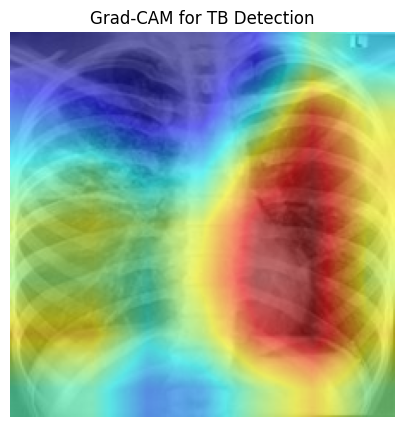

In [20]:
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layers = [model.base.features.denseblock4]

inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

def generate_gradcam(image_path):
    image = Image.open(image_path).convert("RGB")
    input_tensor = inference_transform(image).unsqueeze(0).to(device)


    cam = GradCAM(model=model, target_layers=target_layers)

    targets = [ClassifierOutputTarget(0)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]


    grayscale_cam = np.array(Image.fromarray(grayscale_cam).resize((224, 224)))

    rgb_img = np.array(image).astype(np.float32) / 255.0

    rgb_img = np.array(Image.fromarray((rgb_img * 255).astype(np.uint8)).resize((224, 224))).astype(np.float32) / 255.0
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(8, 5))
    plt.imshow(visualization)
    plt.axis("off")
    plt.title("Grad-CAM for TB Detection")
    plt.show()


generate_gradcam("tb_dataset/TB/TB.1.jpg")

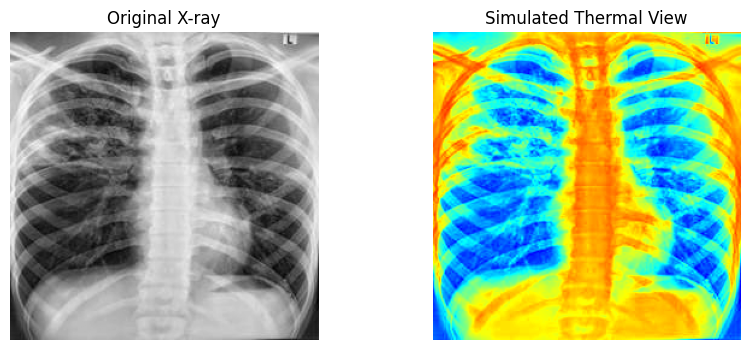

In [21]:
import cv2
import matplotlib.pyplot as plt

def apply_thermal_effect(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    thermal = cv2.applyColorMap(image, cv2.COLORMAP_JET)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap="gray")
    plt.title("Original X-ray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(thermal, cv2.COLOR_BGR2RGB))
    plt.title("Simulated Thermal View")
    plt.axis("off")
    plt.show()

# 🧪 Example
apply_thermal_effect("tb_dataset/TB/TB.1.jpg")

In [24]:
!pip install pymodbus>=3.0.0 # Update to a newer pymodbus version
!pip install timm
!pip install opencv-python
!pip install midas

In [27]:
pip uninstall midas -y

Found existing installation: midas 0.7.0
Uninstalling midas-0.7.0:
  Successfully uninstalled midas-0.7.0


In [28]:
!git clone https://github.com/isl-org/MiDaS.git

Cloning into 'MiDaS'...
remote: Enumerating objects: 622, done.
remote: Counting objects: 100% (245/245), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 622 (delta 183), reused 136 (delta 136), pack-reused 377 (from 2)
Receiving objects: 100% (622/622), 3.44 MiB | 11.74 MiB/s, done.
Resolving deltas: 100% (246/246), done.


In [29]:
import sys
sys.path.append('./MiDaS')